In [114]:
import sys
import os

# Pega o diretório de trabalho atual (que é /notebooks)
notebook_dir = os.getcwd()
# Sobe um nível para o diretório raiz do projeto
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Adiciona a raiz do projeto ao sys.path se ainda não estiver lá
if project_root not in sys.path:
    print(f"Adicionando a raiz do projeto ao path: {project_root}")
    sys.path.append(project_root)

In [115]:
from src.load_df import load_df
from joblib import load

import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = None

In [116]:
# Carregar os DataFrames
df_train = load_df("../data/df_train_selected.parquet")
X_train = df_train.drop('inadimplente', axis=1)
y_train = df_train['inadimplente']

df_test = load_df("../data/df_test_selected.parquet")
X_test = df_test.drop('inadimplente', axis=1)
y_test = df_test['inadimplente']

df_val= load_df("../data/df_val_selected.parquet")
X_val = df_val.drop('inadimplente', axis=1)
y_val = df_val['inadimplente']

In [117]:
# Load the model
model = load("../models/lightgbm_optuna1.joblib")['model']

In [118]:
def calculate_scores(model, df):
    y_pred_proba = model.predict_proba(df)[:, 1]
    scores = 1000 - (y_pred_proba * 1000).astype(int)

    return scores

In [119]:
X_test_processed = X_test.drop(columns=['safra'], axis=1)

credit_scores = calculate_scores(model, X_test_processed)
X_test_scored = X_test.copy()
X_test_scored['credit_score'] = credit_scores

## Análise de Ranqueamento

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import string # Para gerar as letras A, B, C...

def analyze_score_bins_custom(credit_scores, y_test, bins_edges=None, num_bins=10):
    """
    Divide os scores de crédito em bins, calcula estatísticas e adiciona rótulos A, B, C...
    (A = melhor faixa de score).
    """
    
    df_analysis = pd.DataFrame({
        'score': credit_scores,
        'inadimplente_real': y_test
    })

    # --- Lógica de Binning (igual à anterior) ---
    if bins_edges is not None:
        print(f"Usando bins customizados: {bins_edges}")
        labels = [f'{int(bins_edges[i])}-{int(bins_edges[i+1])-1}' for i in range(len(bins_edges)-1)]
        labels[-1] = f'{int(bins_edges[-2])}-{int(bins_edges[-1])}'
        df_analysis['score_bin_range'] = pd.cut(df_analysis['score'], bins=bins_edges, labels=labels,
                                                include_lowest=True, right=True)
        df_analysis.dropna(subset=['score_bin_range'], inplace=True)
    else:
        print(f"Usando {num_bins} bins automáticos (quantis).")
        try:
            df_analysis['score_bin_num'], bin_edges_qcut = pd.qcut(df_analysis['score'], q=num_bins, labels=False, retbins=True, duplicates='drop')
        except ValueError as e:
            print(f"Aviso: Não foi possível criar {num_bins} bins distintos. {e}")
            df_analysis['score_bin_num'], bin_edges_qcut = pd.qcut(df_analysis['score'], q=num_bins, labels=False, retbins=True, duplicates='raise')
            
        bin_edges_qcut = [int(round(b)) for b in bin_edges_qcut]
        labels = [f'{bin_edges_qcut[i]}-{bin_edges_qcut[i+1]-1}' for i in range(len(bin_edges_qcut)-1)]
        labels[-1] = f'{bin_edges_qcut[-2]}-{bin_edges_qcut[-1]}'
        label_map = {i: labels[i] for i in range(len(labels))}
        df_analysis['score_bin_range'] = df_analysis['score_bin_num'].map(label_map)
        df_analysis.drop(columns=['score_bin_num'], inplace=True)

    # --- Calcular Estatísticas (igual à anterior) ---
    stats_per_bin = df_analysis.groupby('score_bin_range', observed=False).agg(
        score_medio=('score', 'mean'),
        score_min=('score', 'min'),
        score_max=('score', 'max'),
        volume=('score', 'count'),
        taxa_inadimplencia_real=('inadimplente_real', 'mean')
    ).reset_index()

    # Ordena pelos scores mínimos (pior para melhor risco)
    stats_per_bin = stats_per_bin.sort_values('score_min').reset_index(drop=True)
    stats_per_bin['score_medio'] = stats_per_bin['score_medio'].round(1)

    # --- NOVO: Adicionar Rótulos A, B, C... ---
    # Gera as letras do alfabeto (A, B, C, ...)
    num_actual_bins = len(stats_per_bin)
    score_labels = list(string.ascii_uppercase[:num_actual_bins])
    
    # Atribui as letras em ordem INVERSA, para que 'A' seja o melhor score (última linha)
    stats_per_bin['score_label'] = score_labels[::-1] 
    
    # Reordena as colunas para melhor visualização
    stats_per_bin = stats_per_bin[['score_label', 'score_bin_range', 'score_min', 'score_max', 'score_medio', 'volume', 'taxa_inadimplencia_real']]

    return stats_per_bin

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# Novas Cores de Alto Contraste
blue = '#006e9cff' 
dark_blue = '#004c6d' # Azul mais escuro para o título
dark_text = '#333333' # Cinza quase preto para máximo contraste
cyan = '#18dbdbff'

def plot_score_bins_analysis(stats_per_bin):
    """
    Versão com fontes grandes e alto contraste para apresentações.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Figura larga para acomodar a legenda sem espremer o gráfico
    fig, ax1 = plt.subplots(figsize=(20, 9)) 

    # 1. ORDENAÇÃO (A -> E)
    plot_data = stats_per_bin.sort_values('score_min', ascending=False).reset_index(drop=True)

    # 2. PLOTAGEM
    bars = ax1.bar(
        plot_data['score_label'], 
        plot_data['taxa_inadimplencia_real'], 
        color=cyan, 
        edgecolor=blue, 
        linewidth=1.5, # Borda mais grossa para contraste
        alpha=0.95,    # Menos transparência para cor mais vibrante
        label='Taxa de Inadimplência Real'
    )

    # 3. ESTILO E FONTES AUMENTADAS
    # Título
    plt.title('Análise da Taxa de Inadimplência Real por Faixa de Score', 
              fontsize=24, color=dark_blue, fontweight='bold', pad=30)
    
    # Eixos
    ax1.set_xlabel('Faixa de Score (A = Menor Risco)', fontsize=16, color=dark_text, fontweight='bold', labelpad=10)
    ax1.set_ylabel('Taxa de Inadimplência Real (%)', fontsize=16, color=dark_text, fontweight='bold', labelpad=10)
    
    # Ticks (Números dos eixos)
    ax1.tick_params(axis='x', labelsize=15, colors=dark_text)
    ax1.tick_params(axis='y', labelsize=14, labelcolor=dark_text)
    
    # Formatação %
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

    # Limpeza visual
    ax1.grid(axis='x', visible=False)
    ax1.grid(axis='y', linestyle='--', alpha=0.4, color='gray') # Grid mais sutil
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_color(dark_text)
    ax1.spines['bottom'].set_linewidth(1.2)

    # 4. RÓTULOS DE DADOS (DATA LABELS)
    # Aumentados para 16pt e cor escura
    ax1.bar_label(bars, fmt='{:.1%}', padding=5, fontsize=16, fontweight='bold', color=dark_text)

    # 5. LEGENDA AJUSTADA (Para não cortar)
    legend_text = "Intervalos de Score:\n\n" + "\n".join(
        [f"  {row['score_label']}  →  {row['score_bin_range']}" for index, row in plot_data.iterrows()]
    )
    
    bbox_props = dict(boxstyle="round,pad=1.5", fc="white", ec="#cccccc", lw=2, alpha=1.0)
    
    # Ajuste de Posição:
    # x=0.81 traz a legenda mais para a esquerda (dentro da área branca)
    fig.text(
        0.81, 0.60, 
        legend_text, 
        fontsize=14, # Fonte da legenda maior
        color=dark_text,
        va='center', 
        ha='left',
        bbox=bbox_props
    )

    # Margem Direita: 
    # rect=[0, 0, 0.80, 1] reserva 20% da largura da imagem para a legenda (antes era 12%)
    plt.tight_layout(rect=[0, 0, 0.80, 1]) 
    
    return fig

Usando bins customizados: [0, 500, 700, 850, 950, 1000]
--- Estatísticas por Faixa de Score ---


,score_label,score_bin_range,score_min,score_max,score_medio,volume,taxa_inadimplencia_real
0,E,0-499,81,500,423.2,2535,0.018146
1,D,500-699,501,700,587.8,4410,0.008163
2,C,700-849,701,850,773.6,1629,0.006753
3,B,850-949,851,950,897.9,677,0.004431
4,A,950-1000,951,999,971.0,244,0.004098


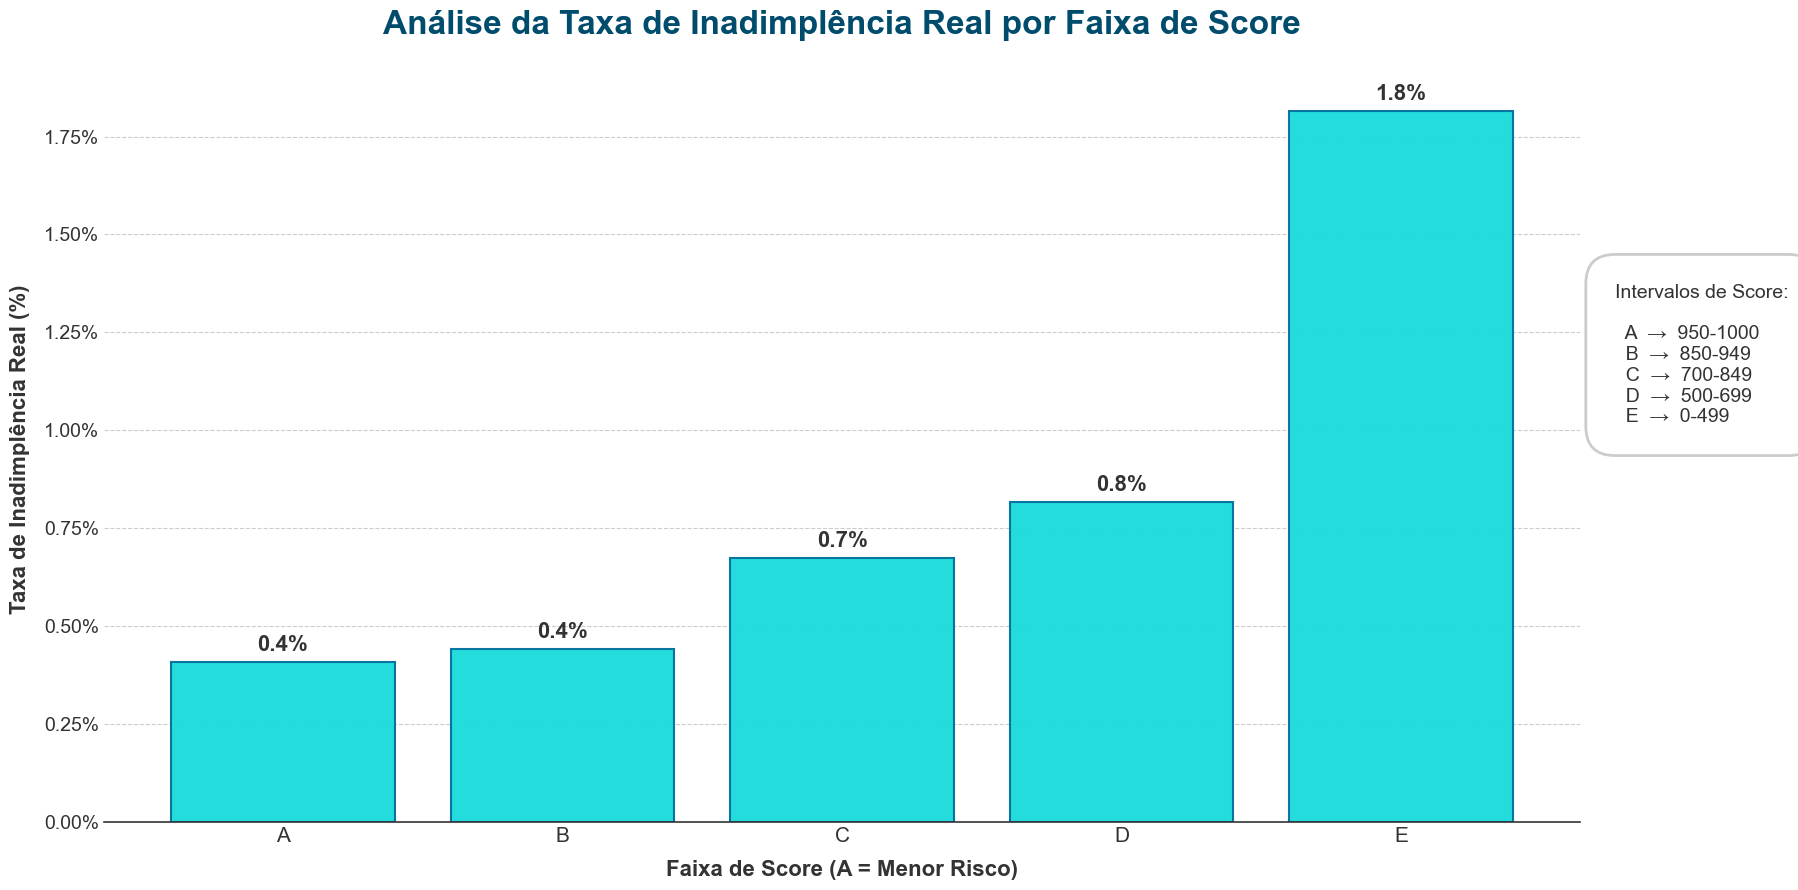

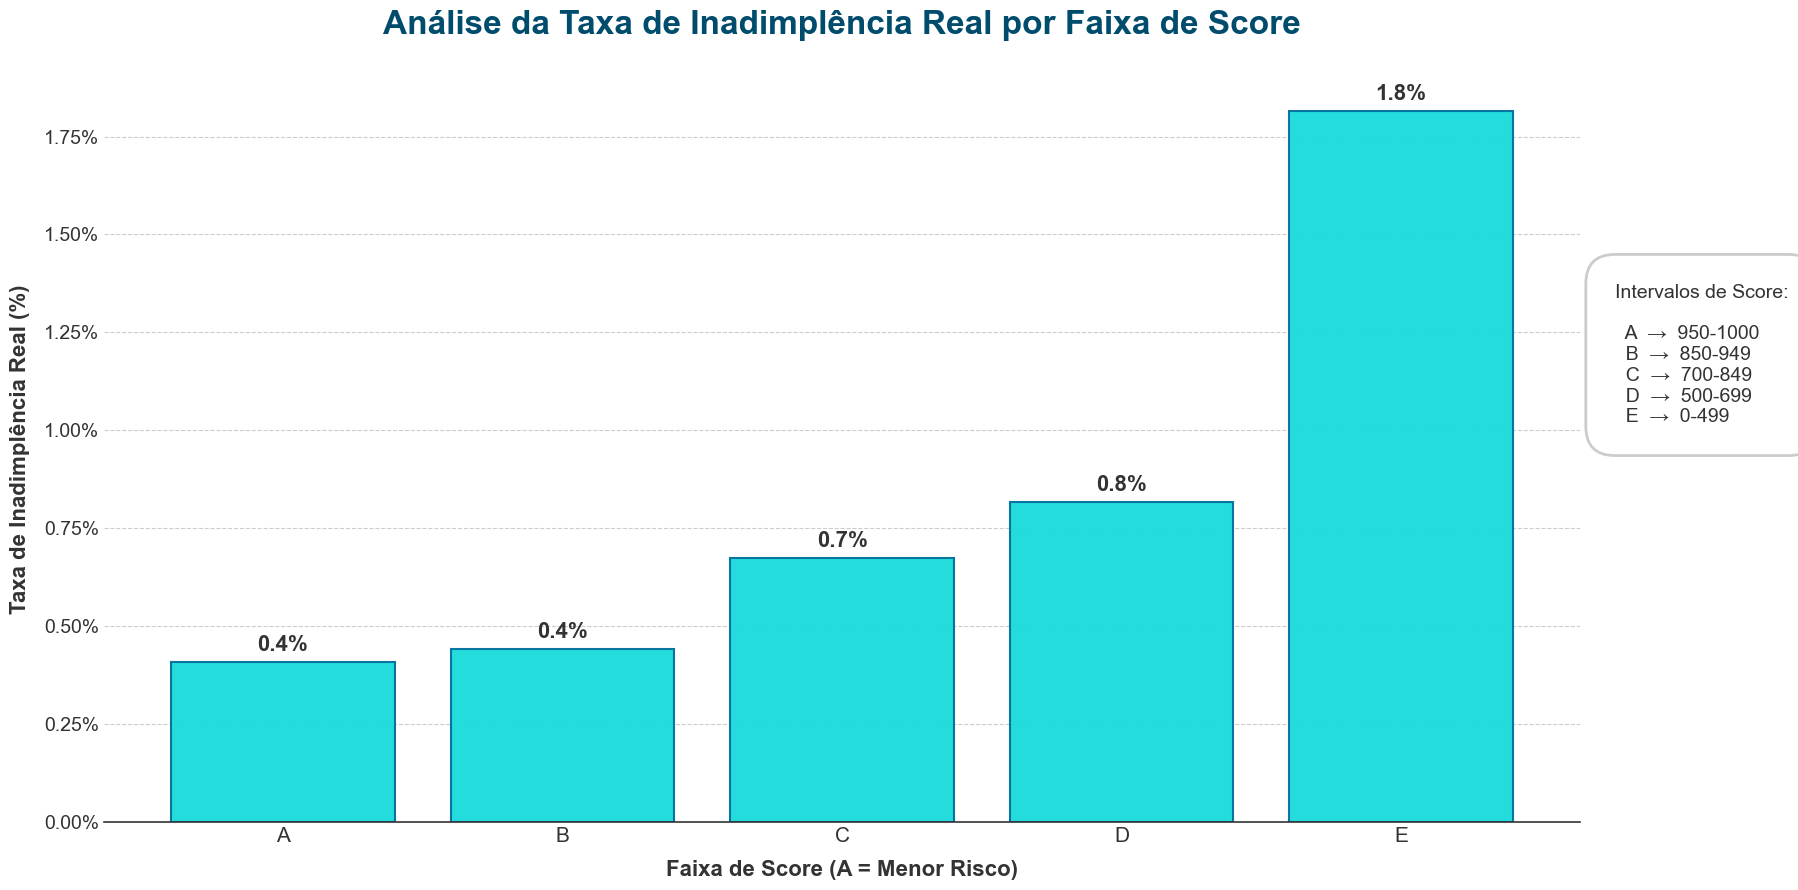

In [121]:
bins_edges = [0, 500, 700, 850, 950, 1000]

stats_df = analyze_score_bins_custom(credit_scores, y_test, bins_edges=bins_edges)

# 3. Exiba a tabela de estatísticas
print("--- Estatísticas por Faixa de Score ---")
display(stats_df)

# 4. Plote o gráfico
plot_score_bins_analysis(stats_df)

## Uniformização dos Scores

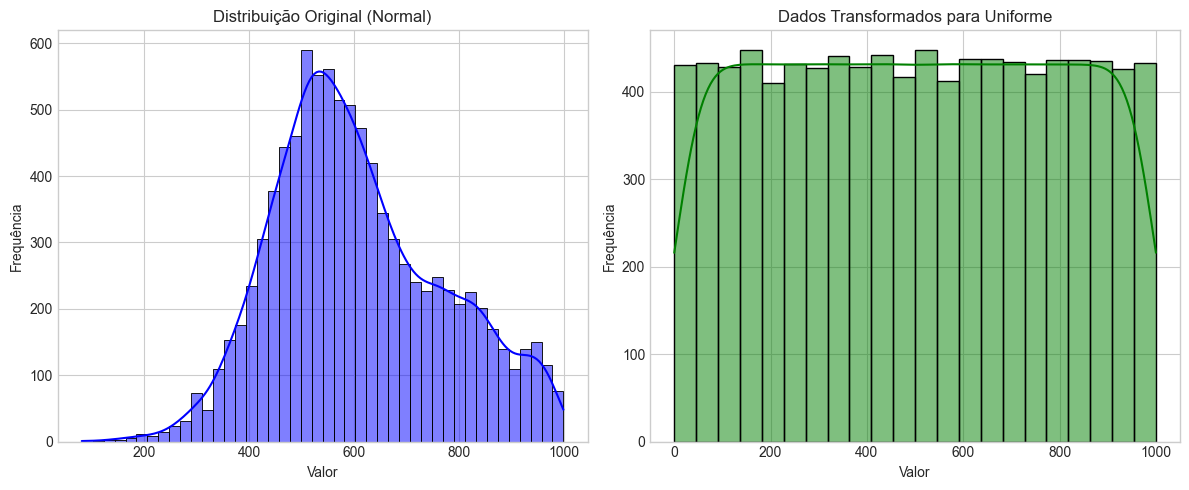

In [122]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform', random_state=0)

credit_scores_uniformed = qt.fit_transform(credit_scores.reshape(-1, 1))

X_test_scored_uniformed = X_test_scored.copy()

# 4. Visualizar os resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma dos dados originais (normais)
sns.histplot(credit_scores, kde=True, ax=ax1, color='blue')
ax1.set_title('Distribuição Original (Normal)')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Frequência')

credit_scores_uniformed = credit_scores_uniformed.flatten()*1000
X_test_scored_uniformed['credit_score'] = credit_scores_uniformed

# Histograma dos dados transformados (uniformes)
sns.histplot(credit_scores_uniformed, kde=True, ax=ax2, color='green')
ax2.set_title('Dados Transformados para Uniforme')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frequência')

plt.tight_layout()
plt.show()

Usando 3 bins automáticos (quantis).
--- Estatísticas por Faixa de Score ---


,score_label,score_bin_range,score_min,score_max,score_medio,volume,taxa_inadimplencia_real
0,C,0-333,0.000000,333.833834,167.9,3189,0.016933
1,B,334-666,337.337337,667.167167,501.9,3153,0.007929
2,A,667-1000,668.668669,1000.000000,834.0,3153,0.005709


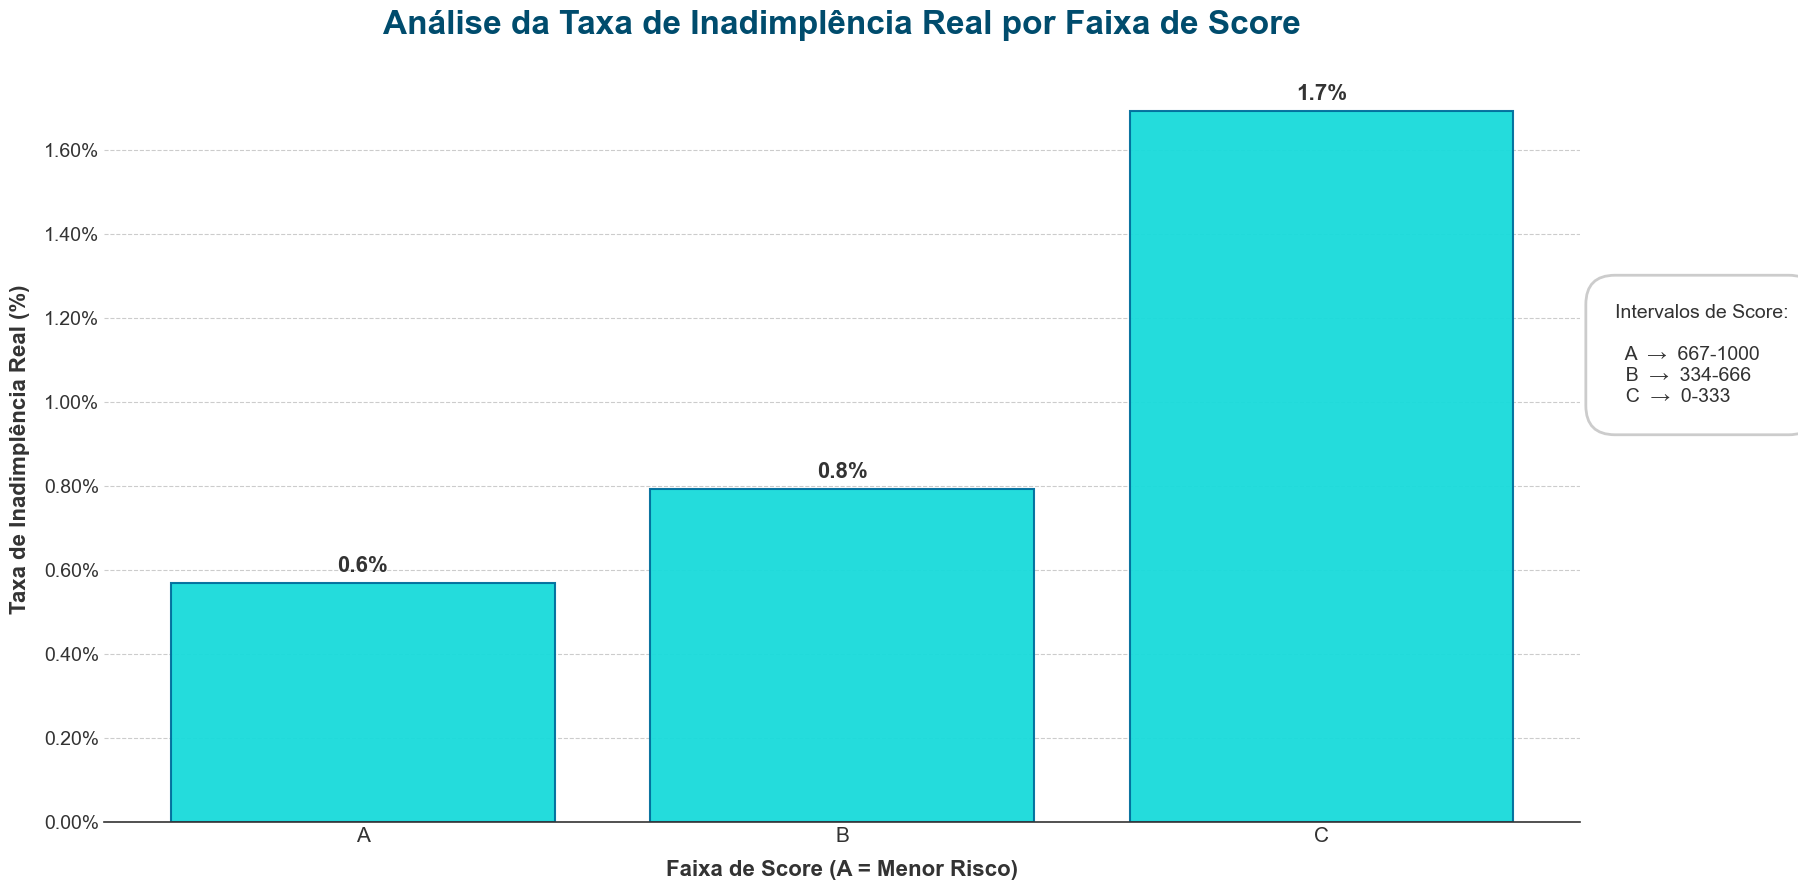

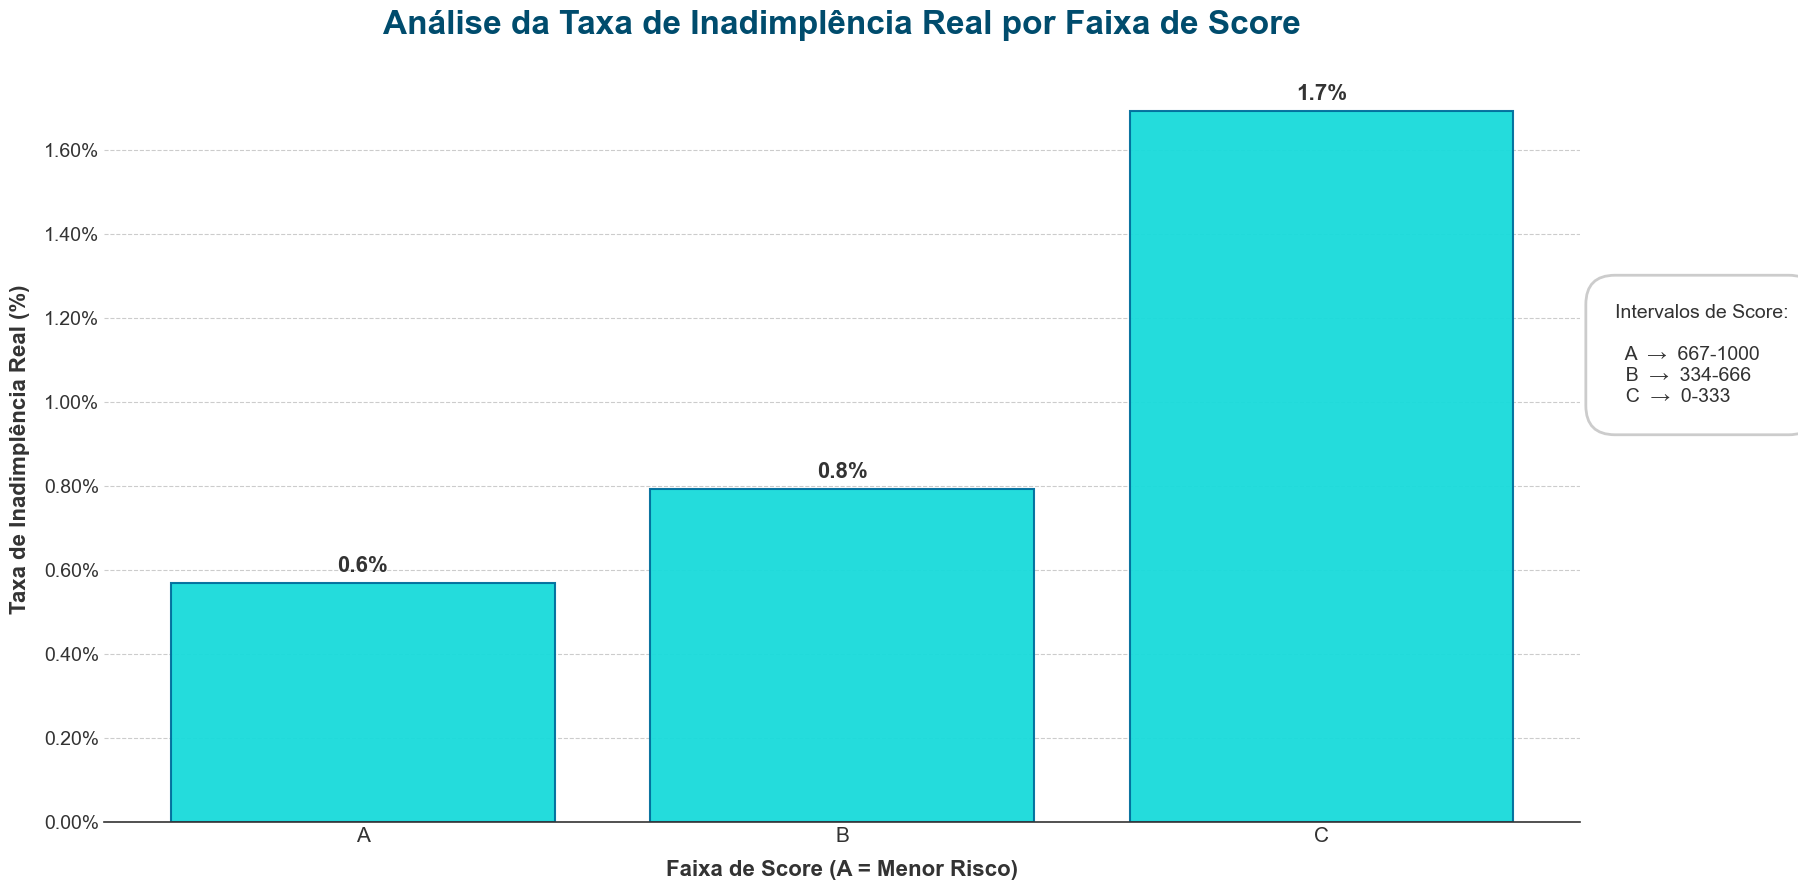

In [123]:
num_bins = 3

stats_df = analyze_score_bins_custom(credit_scores_uniformed, y_test, num_bins=num_bins)

print("--- Estatísticas por Faixa de Score ---")
display(stats_df)

plot_score_bins_analysis(stats_df)

## Avaliação por Safra

In [124]:
def assign_score_labels(dataframe, bins_edges=None, num_bins=10):
    """
    Atribui rótulos de faixa de score (A, B, C...) a uma série de scores.
    'A' representa a faixa de score mais alta (melhor risco).

    Args:
        credit_scores (pd.Series or np.array): Scores de crédito calculados.
        bins_edges (list or None): Lista com os limites das faixas de score.
                                   Se None, usa quantis automáticos (num_bins).
        num_bins (int): Número de quantis a serem criados se bins_edges for None.

    Returns:
        pd.Series: Série contendo o rótulo da faixa ('A', 'B', ...) para cada score.
    """
    df_temp = pd.DataFrame({'score': dataframe['credit_score']})
    num_actual_bins = 0

    if bins_edges is not None:
        num_actual_bins = len(bins_edges) - 1
        # Cria labels numéricos temporários (0 a N-1)
        df_temp['bin_num'] = pd.cut(df_temp['score'], bins=bins_edges, labels=False,
                                    include_lowest=True, right=True, duplicates='drop')
    else:
        num_actual_bins = num_bins
        try:
            df_temp['bin_num'] = pd.qcut(df_temp['score'], q=num_bins, labels=False, duplicates='drop')
        except ValueError:
            # Se qcut falhar, pode retornar menos bins
             df_temp['bin_num'] = pd.qcut(df_temp['score'], q=num_bins, labels=False, duplicates='raise')
             num_actual_bins = df_temp['bin_num'].nunique() # Atualiza o número real de bins

    # Gera as letras (A, B, C...)
    score_labels_list = list(string.ascii_uppercase[:num_actual_bins])
    
    # Cria o mapeamento: bin numérico -> Letra (invertido, 0=pior -> J, 9=melhor -> A)
    # Ordenamos os bins numéricos do maior para o menor score antes de mapear
    label_map = {bin_num: score_labels_list[i] for i, bin_num in enumerate(sorted(df_temp['bin_num'].unique(), reverse=True))}
    
    # Aplica o mapeamento para obter a coluna final de rótulos
    score_label_series = df_temp['bin_num'].map(label_map)

    dataframe['score_label'] = score_label_series
    
    return dataframe

In [139]:
def plot_default_rate_over_time_by_score_band(X_test, y_test):
    """
    Plota a taxa de inadimplência real ao longo do tempo (safra) para cada faixa de score.

    Args:
        X_test (pd.DataFrame): DataFrame de teste contendo a coluna 'safra'.
        y_test (pd.Series or np.array): Valores reais da variável target para o teste.
        score_labels (pd.Series): Série com os rótulos ('A', 'B', ...) para cada registro em X_test.
    """
    
    # 1. Combinar os dados necessários
    df_plot = pd.DataFrame({
        'safra': X_test['safra'],
        'score_label': X_test['score_label'],
        'inadimplente_real': y_test
    })

    # 2. Calcular a taxa de inadimplência por safra e por faixa de score
    # Usamos observed=False para garantir que todas as faixas apareçam mesmo se vazias em alguma safra
    default_rate_over_time = df_plot.groupby(['safra', 'score_label'], observed=False)['inadimplente_real'].mean().reset_index()

    # Ordena para garantir que as safras e labels estejam na ordem correta
    default_rate_over_time = default_rate_over_time.sort_values(['safra', 'score_label'])

    # 3. Plotar o gráfico de linhas
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    ax = sns.lineplot(
        data=default_rate_over_time,
        x='safra',
        y='inadimplente_real',
        hue='score_label', # Uma linha para cada faixa de score
        marker='o',
        # palette='viridis_r' # Exemplo de paleta de cores (opcional)
    )

    # Melhorar a formatação
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    plt.title('Evolução da Taxa de Inadimplência Real por Safra e Faixa de Score', fontsize=16, pad=20)
    plt.xlabel('Safra (Ano-Mês)', fontsize=14)
    plt.ylabel('Taxa de Inadimplência Real (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Faixa de Score (A=Melhor)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14) # Legenda fora do gráfico
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # aumentar fonte dos ticks
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # aumentar fonte da legenda
    legend = ax.get_legend()
    for text in legend.get_texts():
        text.set_fontsize(12)

    plt.tight_layout()
    plt.show()

In [140]:
bins_edges = [0, 333, 666, 1000]

X_test_labeled = assign_score_labels(X_test_scored_uniformed, bins_edges=bins_edges)

X_test_labeled['score_label'].value_counts()

score_label
A    3174
B    3166
C    3155
Name: count, dtype: int64

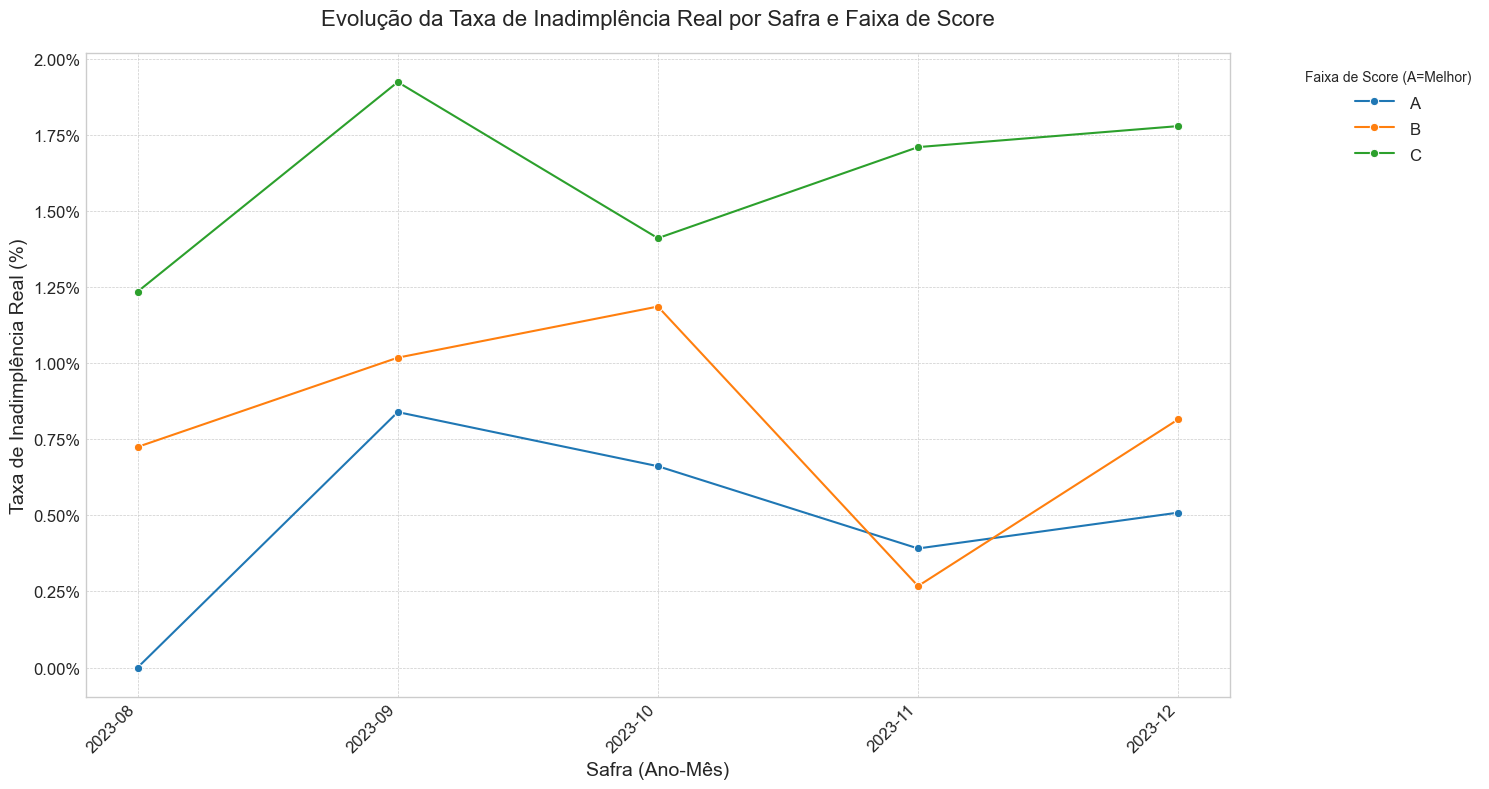

In [141]:
plot_default_rate_over_time_by_score_band(X_test_labeled, y_test)

## AUC por Safra

In [128]:
def plot_auc_over_time(model, dataframe, y_test):
    """
    Calcula e plota o AUC do modelo para cada safra no conjunto de teste.

    Args:
        model: O modelo treinado.
        dataframe (pd.DataFrame): DataFrame de teste com as features finais (numéricas).
        y_test (pd.Series or np.array): Valores reais da variável target para o teste.
    """
    print("Calculando AUC por safra...")

    # 1. Obter as probabilidades previstas
    if hasattr(model, 'feature_name_') or hasattr(model, 'feature_names_in_'):
        training_cols = model.feature_name_ if hasattr(model, 'feature_name_') else model.feature_names_in_
        missing_cols = set(training_cols) - set(dataframe.columns)
        if missing_cols:
                print(f"Colunas faltando em dataframe: {missing_cols}")
                return
        try:
            y_pred_proba = model.predict_proba(X_test[training_cols])[:, 1]
        except Exception as inner_e:
            print(f"Erro mesmo após seleção de colunas: {inner_e}")
            return
    else:
        return


    # 2. Combinar dados
    df_auc_analysis = pd.DataFrame({
        'safra': dataframe['safra'],
        'y_real': y_test,
        'probabilidade_inadimplencia': y_pred_proba
    })

    # 3. Calcular AUC por safra
    auc_per_safra = []
    safras = sorted(df_auc_analysis['safra'].unique())

    for s in safras:
        df_safra = df_auc_analysis[df_auc_analysis['safra'] == s]
        
        # Verifica se há ambas as classes (0 e 1) na safra para calcular AUC
        if len(df_safra['y_real'].unique()) < 2:
            print(f"Aviso: Safra {s} tem apenas uma classe. AUC não pode ser calculado, será NaN.")
            auc_score = np.nan
        else:
            auc_score = roc_auc_score(df_safra['y_real'], df_safra['probabilidade_inadimplencia'])
            
        auc_per_safra.append({'safra': s, 'auc': auc_score})

    df_auc_results = pd.DataFrame(auc_per_safra)

    print("\n--- AUC por Safra ---")
    display(df_auc_results)

    # 4. Plotar o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))

    plt.plot(df_auc_results['safra'], df_auc_results['auc'], marker='o', linestyle='-', color='dodgerblue')

    # Calcular e plotar AUC médio (ignorando NaNs)
    auc_medio = df_auc_results['auc'].mean()
    plt.axhline(auc_medio, color='grey', linestyle='--', label=f'AUC Médio = {auc_medio:.4f}')

    # Formatação
    plt.title('Evolução do AUC por Safra (Teste OOT)', fontsize=16, pad=20)
    plt.xlabel('Safra (Ano-Mês)', fontsize=12)
    plt.ylabel('AUC-ROC', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=max(0, df_auc_results['auc'].min() - 0.05), top=min(1, df_auc_results['auc'].max() + 0.05)) # Ajusta limites do eixo Y
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

Calculando AUC por safra...

--- AUC por Safra ---


,safra,auc
0,2023-08,0.689038
1,2023-09,0.637548
2,2023-10,0.602678
3,2023-11,0.674264
4,2023-12,0.670696


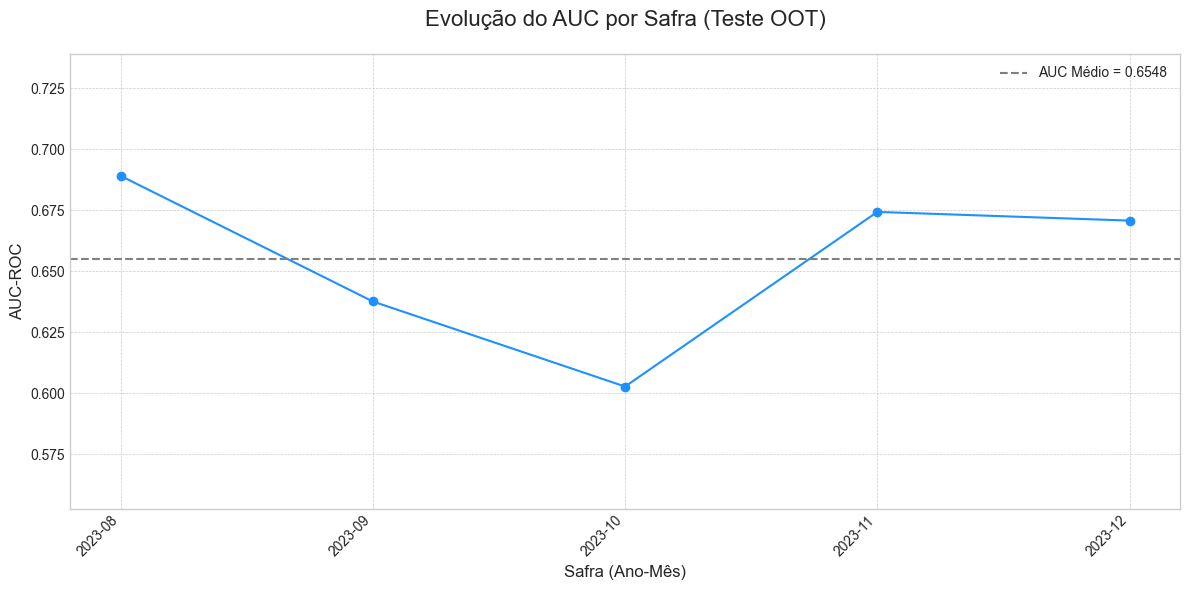

In [129]:
plot_auc_over_time(model, X_test_labeled, y_test)